# BANK-MAKETING ANALYSIS

<img src="images/telemarketing.png">
<br><hr><br>
##### Consultores:

- Anderson
- Caio Viera
- Pedro Correia

Com o objetivo de modelar a efetividade da campanha de marketing do Banco Banco S.A., apresenta-se aqui uma exploração das variáveis levantadas referentes à [última campanha realizada](https://archive.ics.uci.edu/ml/datasets/bank+marketing).

A seguir, a descrição de cada uma das variáveis disponíveis:

### Input variables:
#### bank client data:

   1. age (numeric)
   2. job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   3. marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   4. education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   5. default: has credit in default? (categorical: "no","yes","unknown")
   6. housing: has housing loan? (categorical: "no","yes","unknown")
   7. loan: has personal loan? (categorical: "no","yes","unknown")
   
#### related with the last contact of the current campaign:

   8. contact: contact communication type (categorical: "cellular","telephone") 
   9. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   10. day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
   11. duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
  
#### other attributes:
  
   12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
   14. previous: number of contacts performed before this campaign and for this client (numeric)
   15. poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  
#### social and economic context attributes
   
   16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
   17. cons.price.idx: consumer price index - monthly indicator (numeric)     
   18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
   19. euribor3m: euribor 3 month rate - daily indicator (numeric)
   20. nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
  
   21. y - has the client subscribed a term deposit? (binary: "yes","no")


### Missing Attribute Values: 
There are several missing values in some categorical attributes, all coded with the "unknown" label. These missing values can be treated as a possible class label or using deletion or imputation techniques. 


<hr>

Incializando o ambiente:
- Importando Bibliotecas
- Carregando os dados

In [1]:
# importando as bibliotecas utilizadas nessa

# data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')
cp = sns.color_palette()
%matplotlib inline

# extras
import warnings
warnings.filterwarnings('ignore')

# 
from bma_functions import *

In [2]:
# carregando os dados
data = load_data('data/historical-data.csv')
data.shape

(37069, 22)

In [3]:
data.head().T

,0,1,2,3,4
age,36,37,50,38,54
job,admin.,self-employed,blue-collar,student,housemaid
marital,married,married,married,divorced,married
education,high.school,basic.9y,basic.9y,unknown,professional.course
default,no,no,unknown,no,no
housing,unknown,yes,no,no,no
loan,unknown,yes,no,no,no
contact,cellular,telephone,cellular,cellular,cellular
month,jul,may,aug,may,jul
day_of_week,fri,fri,thu,tue,tue


### Variável Resposta

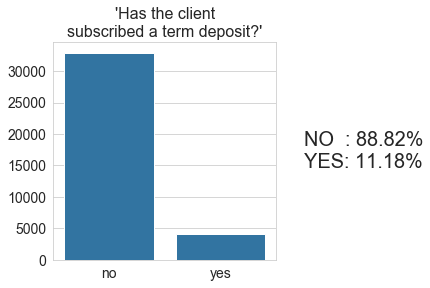

In [4]:
plot_target(data, savefig=True);

Percebe-se que o target de nosso dataset apresenta significativo desbalanceamento. Com isso, faz-se necessário ter especial atenção ao *recall* atingido pelo modelo.

### Dados Categóricos

In [5]:
data_cat = get_categorical_fields(data)

In [6]:
# avaliando a cardinalidade das variáveis categóricas
print_cardinalities(data_cat)

There are 10 categorical features in the data set:
  - job            (cardinality: 12)
  - marital        (cardinality: 4)
  - education      (cardinality: 8)
  - default        (cardinality: 3)
  - housing        (cardinality: 3)
  - loan           (cardinality: 3)
  - contact        (cardinality: 2)
  - month          (cardinality: 10)
  - day_of_week    (cardinality: 5)
  - poutcome       (cardinality: 3)


Nenhuma cardinalidade parece excessiva, de forma que não vamos tratar adicionalmente esse aspecto de nosso dataset.

Vamos buscar entender, na sequência, de forma individualizada como se comportam essas variáveis frente à proporção generalizada da variável resposta.

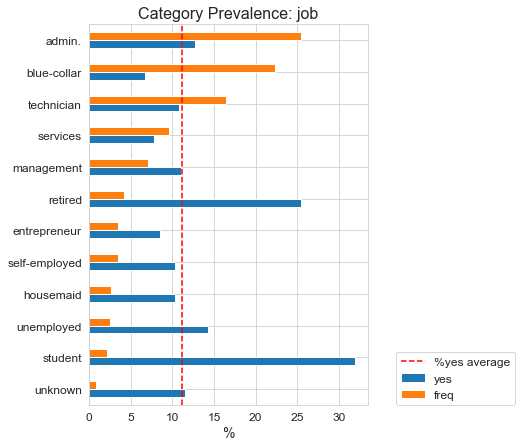

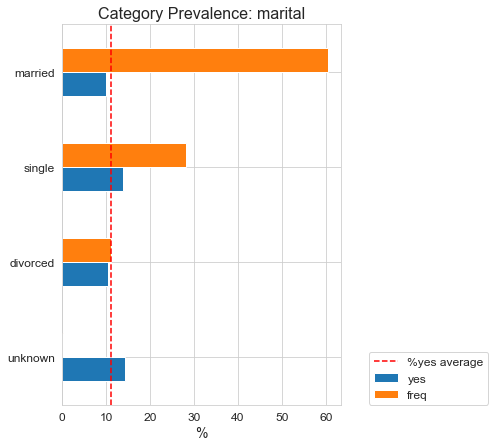

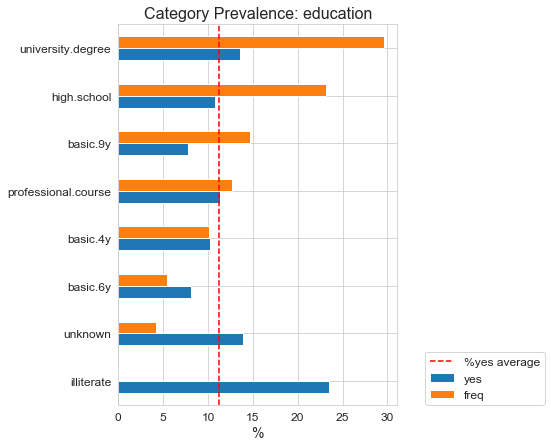

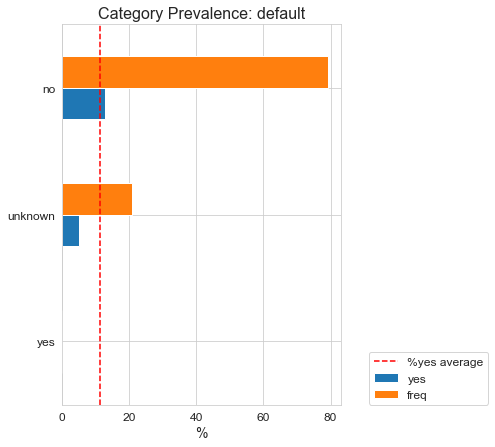

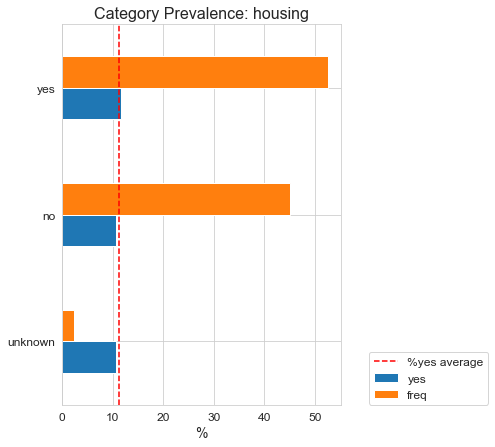

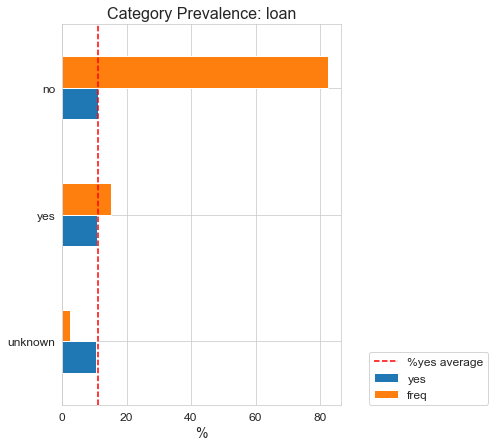

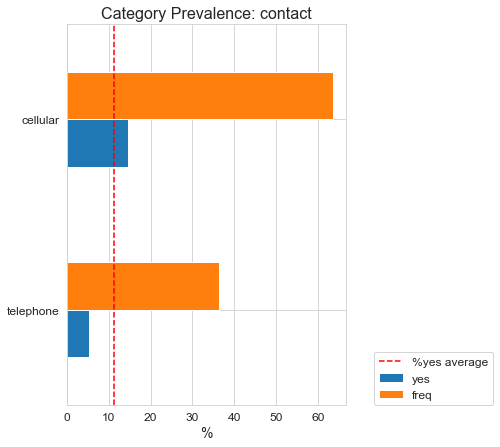

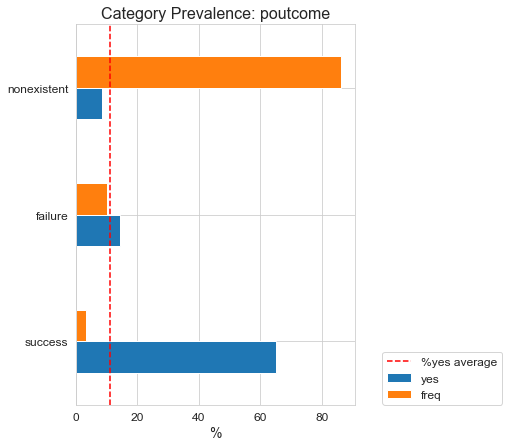

In [7]:
data_cat['y_numeric'] = data['y_numeric'] # target encodado para facilitar agregações
for cat_feature in data_cat.columns[:-2]:
    if cat_feature not in ('month', 'day_of_week'): # temporal data requires different approach
        plot_cat_prevalence(data_cat, cat_feature, savefig=True)

### Dados Numéricos

In [8]:
data_num = data.select_dtypes(include = ['float64', 'int64'])

Para os dados numéricos, vamos, inicialmente vamos observar suas distribuições

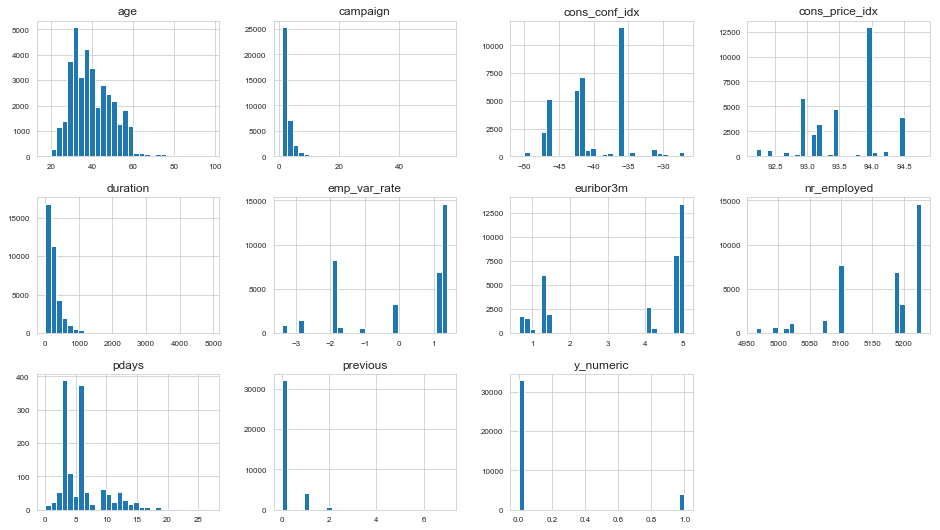

In [21]:
data_num_2plot = data_num.copy()
data_num_2plot.loc[data_num['pdays'] == 999, 'pdays'] = np.nan # tratamento necessário exclusivamente pelo grande número de valores 999 nessa variável
data_num_2plot.hist(bins=30, xlabelsize=8, ylabelsize=8, figsize=(16, 9), layout=(3,4));

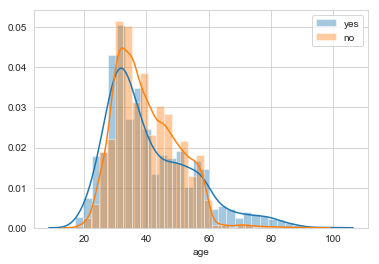

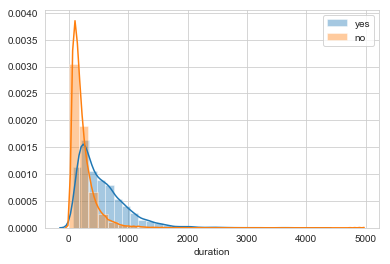

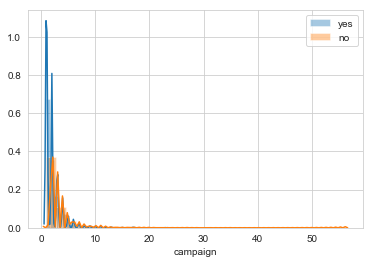

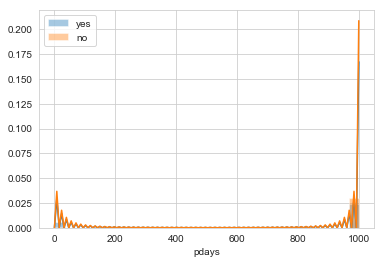

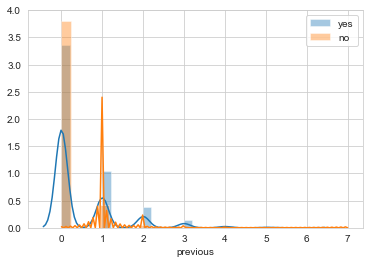

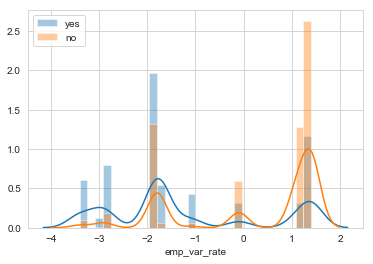

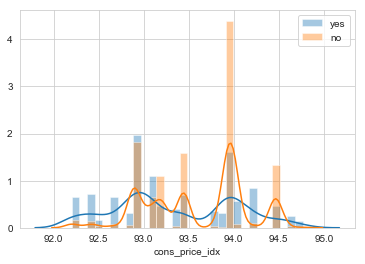

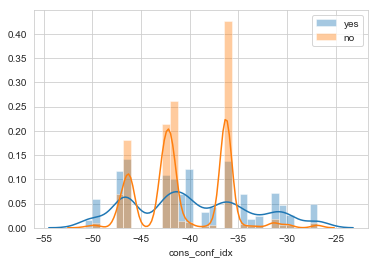

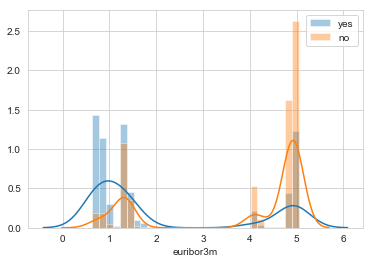

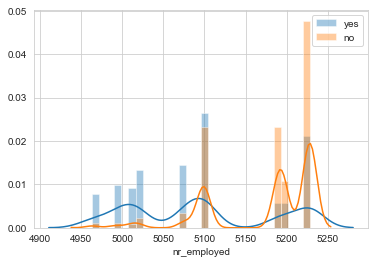

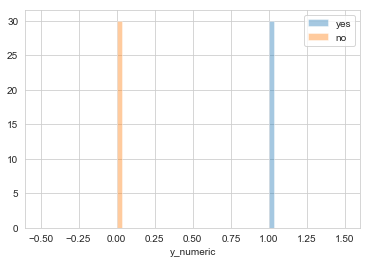

In [37]:
for c in data_num.columns:
    fig, ax = plt.subplots()
    ax = sns.distplot(data_num.loc[data_num['y_numeric']==1, c], ax=ax, bins=30, label='yes')
    ax = sns.distplot(data_num.loc[data_num['y_numeric']!=1, c], ax=ax, bins=30, label='no')
    ax.legend(loc='best')